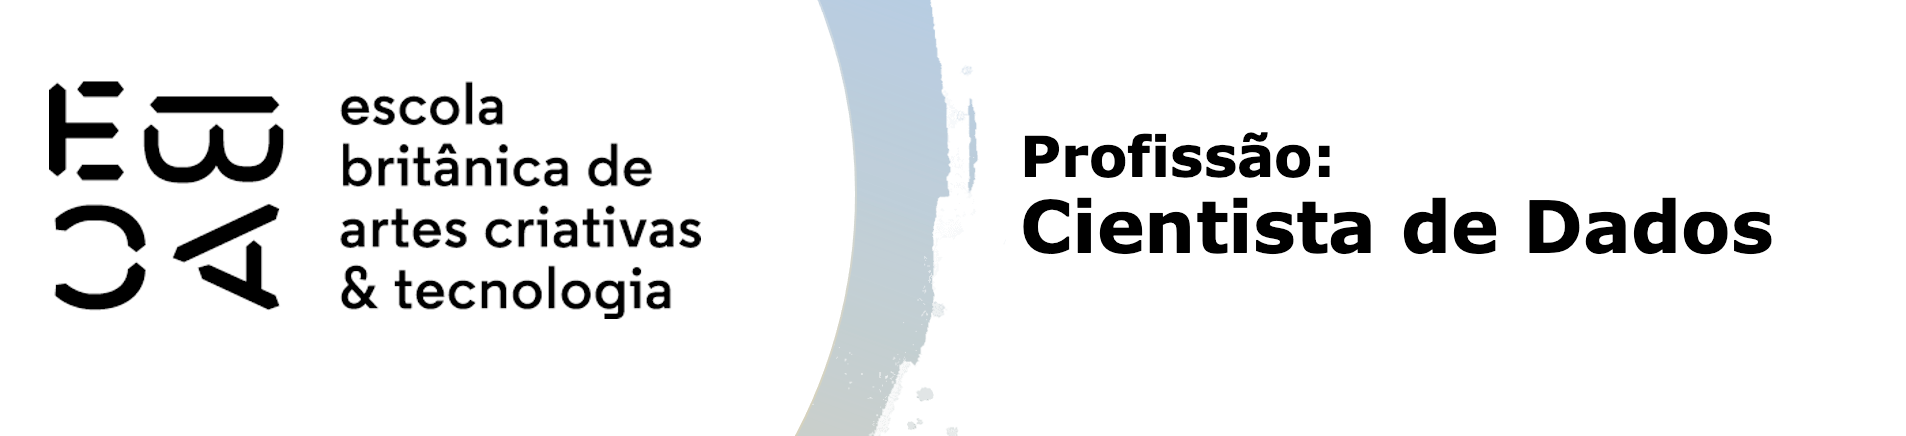

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from scipy.stats import t
from sklearn.model_selection import train_test_split
from pycaret.classification import *

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_curve, auc

df = pd.read_feather('./credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
safra = df.data_ref.max()

safra =  safra - pd.DateOffset(months=3)

df_val =  df[df['data_ref'] > safra]

df_val

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [3]:
df_treino = df[df['data_ref'] <= safra]
df_treino

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False
599997,2015-12-01,13085,F,N,N,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5117.17,True
599998,2015-12-01,10964,F,N,N,0,Assalariado,Superior completo,Casado,Casa,40,12.939726,2.0,2885.45,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

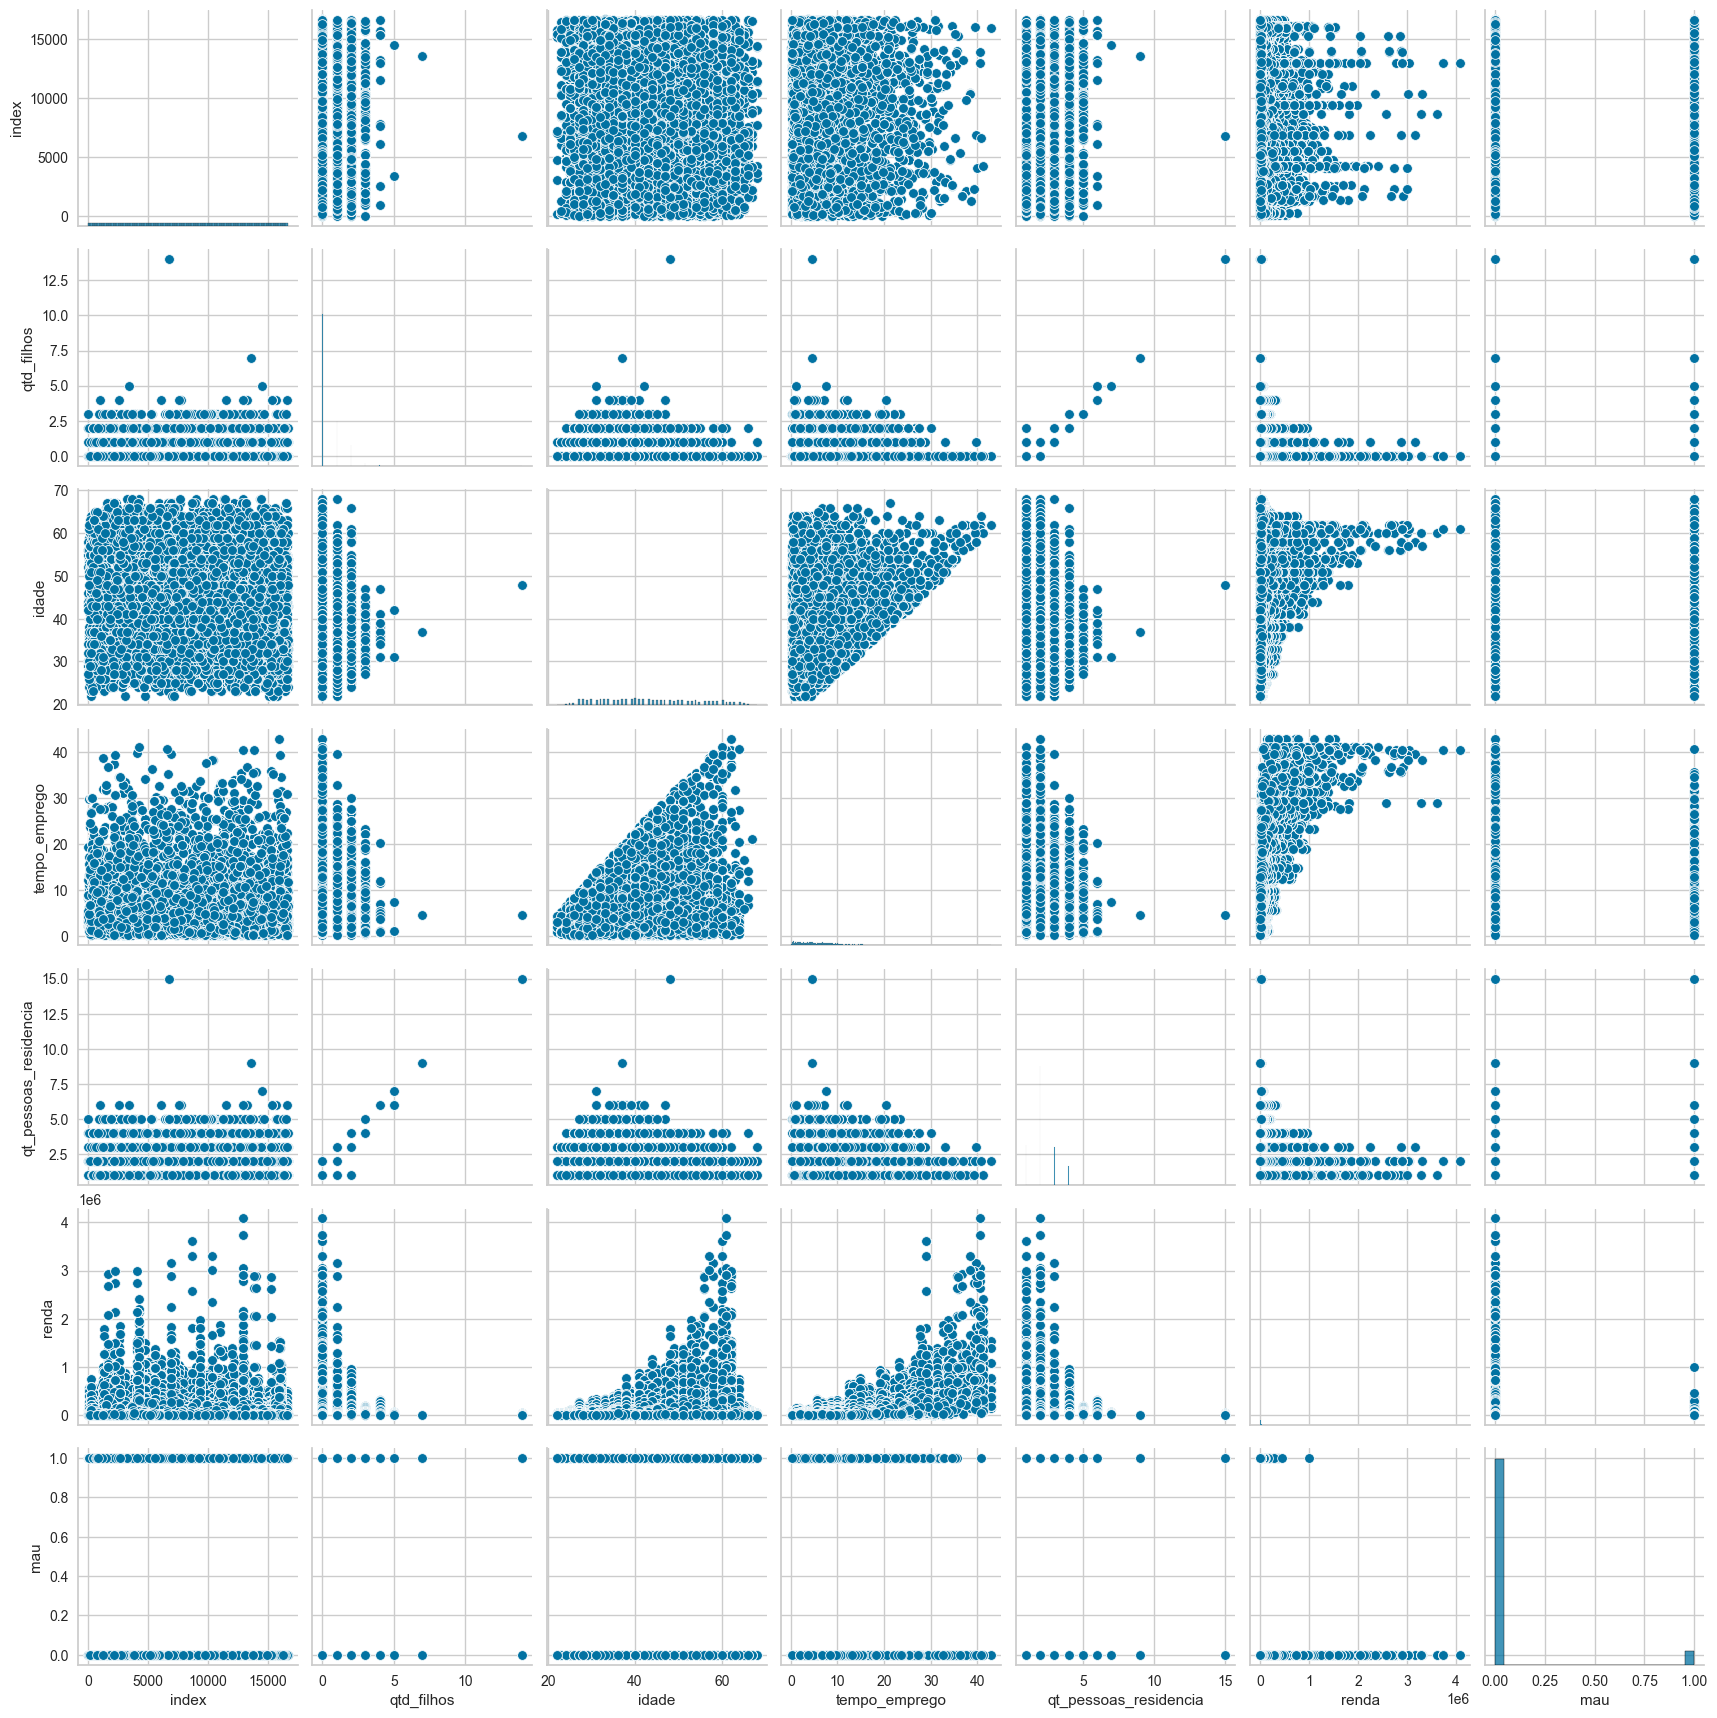

In [4]:
sns.pairplot(df_treino)

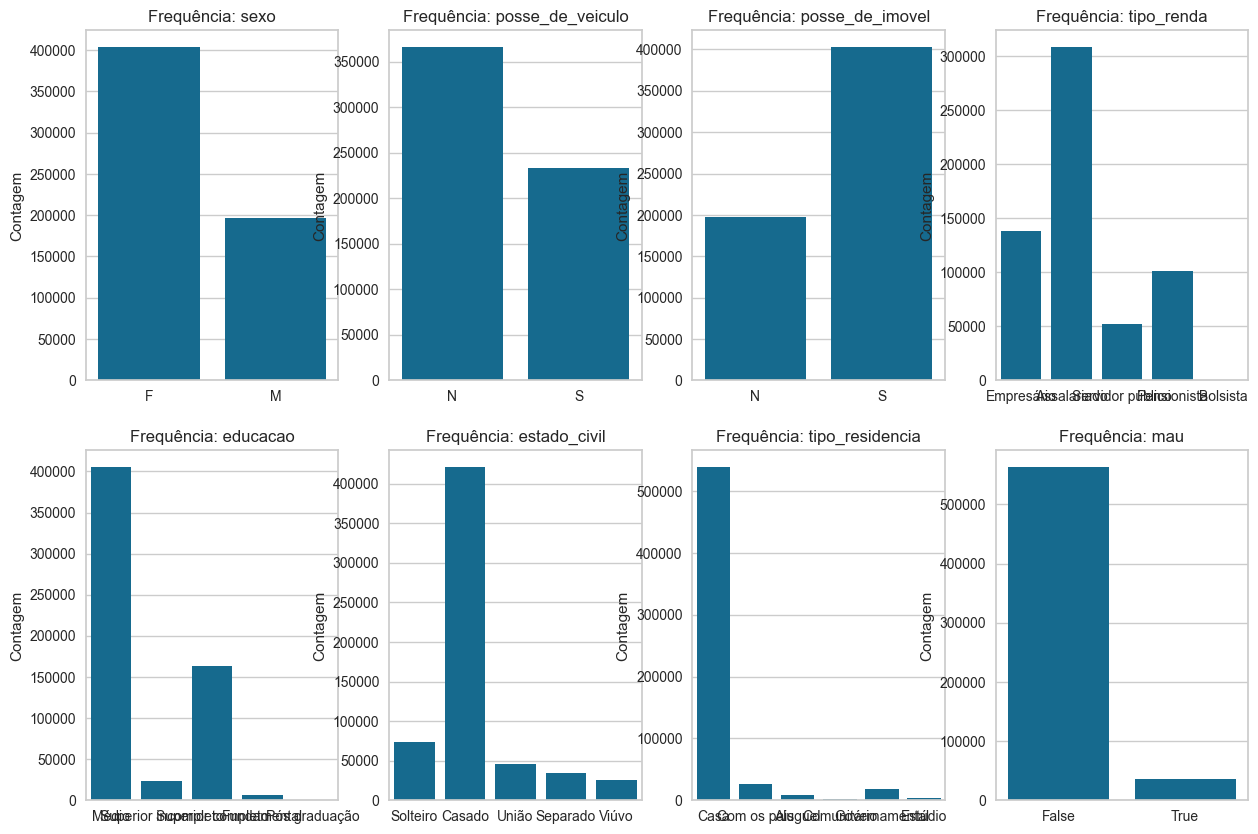

In [5]:
colunas_qualitativas = df_treino.select_dtypes(include=["object","bool"]).columns
n = len(colunas_qualitativas)

linhas = (n // 4) + (n % 4 > 0)
fig, axes = plt.subplots(linhas, 4, figsize=(15, 5 * linhas))

axes = axes.flatten()

for i, coluna in enumerate(colunas_qualitativas):
    ax = axes[i]
    sns.countplot(data=df_treino, x=coluna, ax=ax)
    ax.set_title(f"Frequência: {coluna}")
    ax.set_xlabel("")
    ax.set_ylabel("Contagem")

In [6]:
total = [df_treino.shape[0], df_val.shape[0]]

print(f'Quantidade de linhas do banco de dados de treino: {total[0]} e no banco de dados de validação: {total[1]}')

Quantidade de linhas do banco de dados de treino: 600000 e no banco de dados de validação: 150000


In [7]:
df_treino['mes'] = df_treino['data_ref'].dt.to_period("M")
quantidade_treino = df_treino['mes'].value_counts().sort_index()
print(f'Quantidade de meses na base de treino: {quantidade_treino}')

Quantidade de meses na base de treino: mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
Freq: M, Name: count, dtype: int64


In [8]:
df_val['mes'] = df_val['data_ref'].dt.to_period("M")
quantidade_val = df_val['mes'].value_counts().sort_index()
print(f'Quantidade de meses na base de validação: {quantidade_val}')

Quantidade de meses na base de validação: mes
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

TypeError: Cannot pass values for both `x` and `y`.

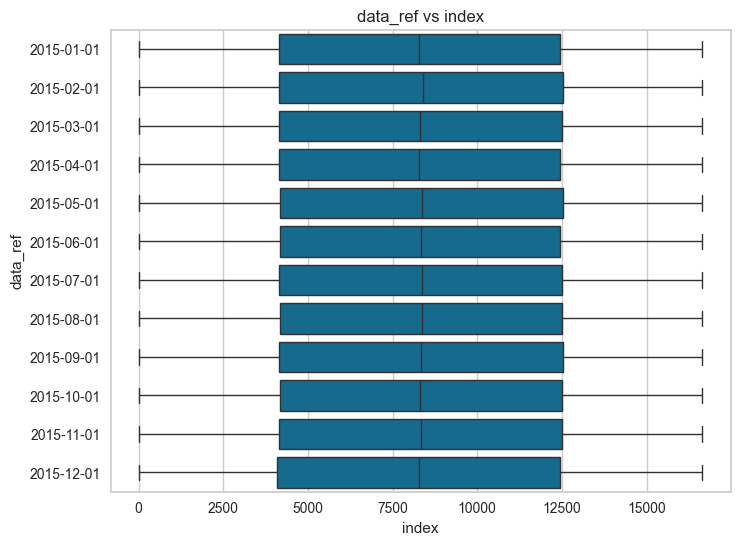

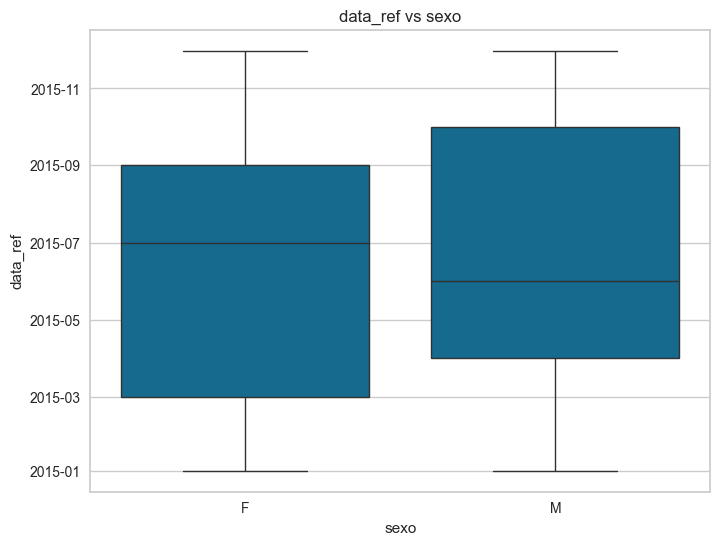

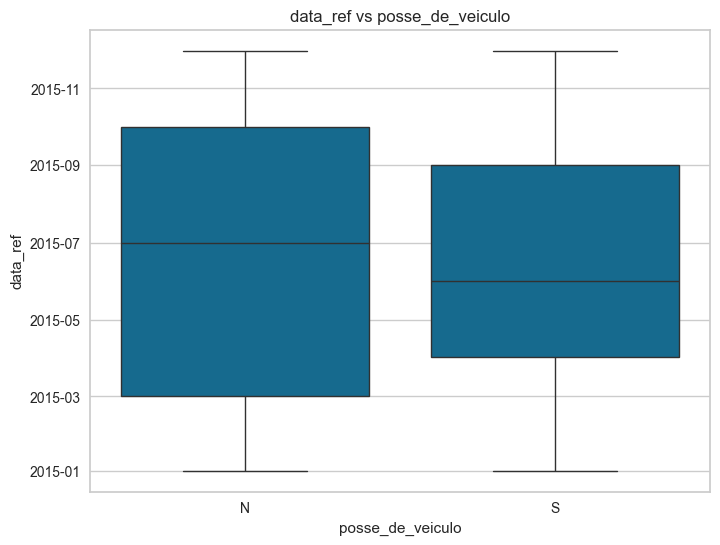

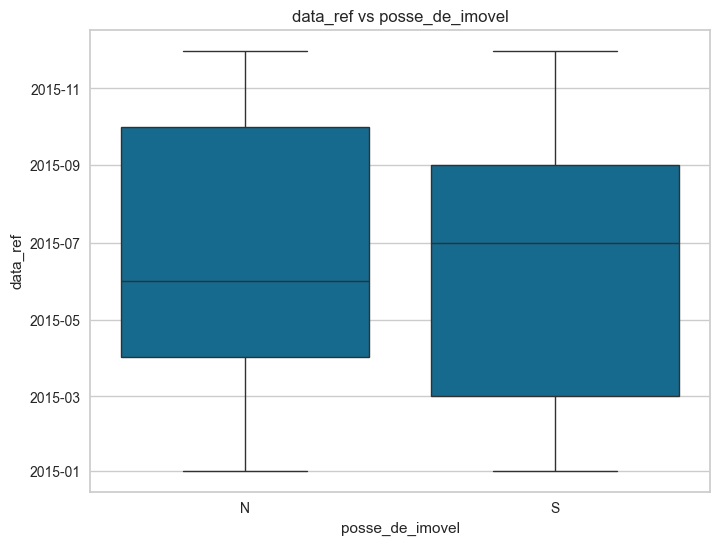

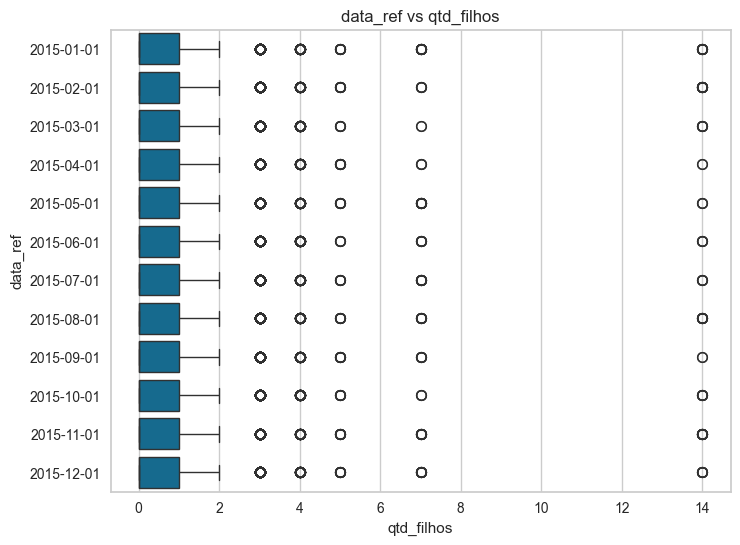

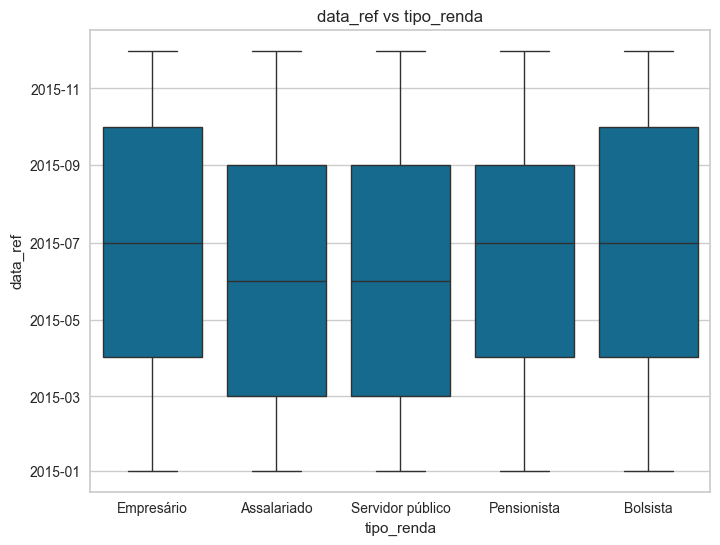

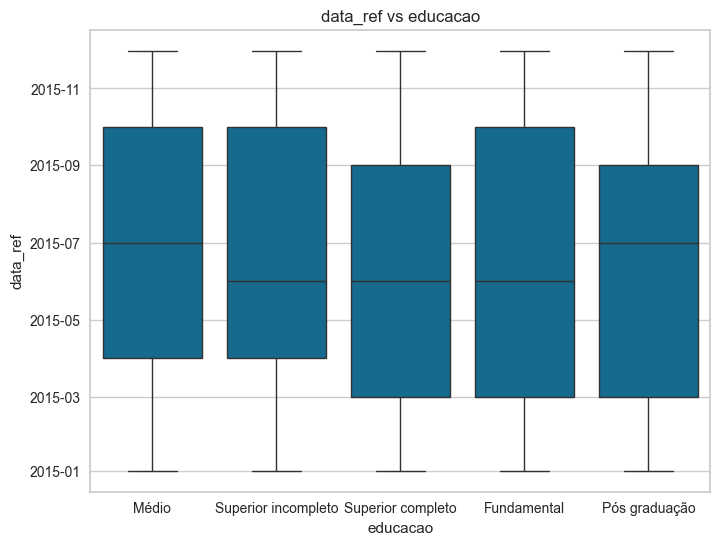

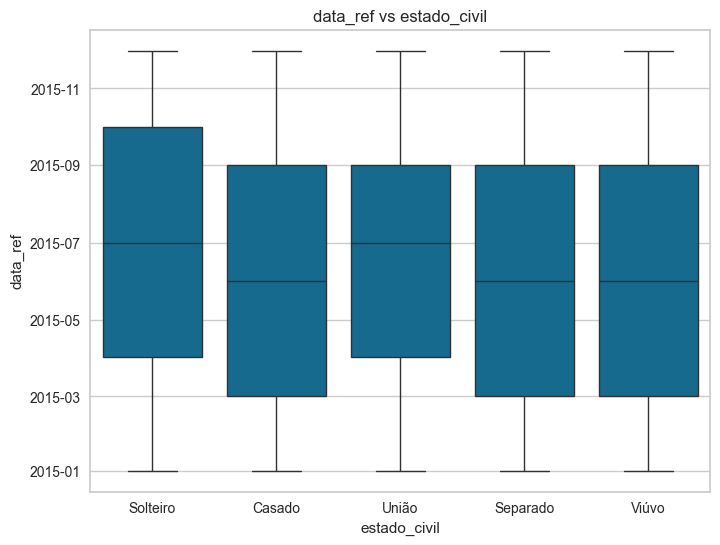

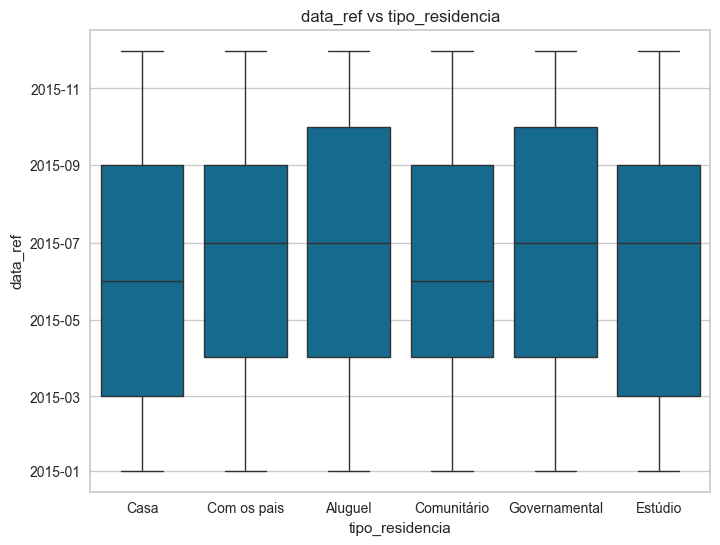

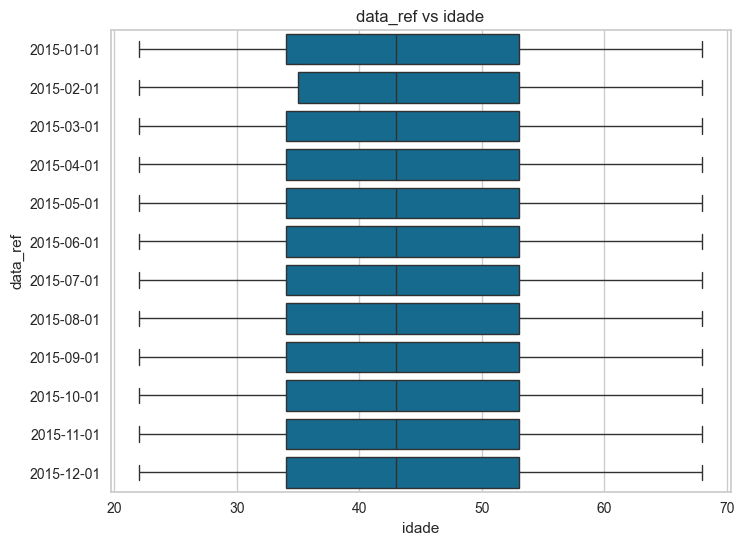

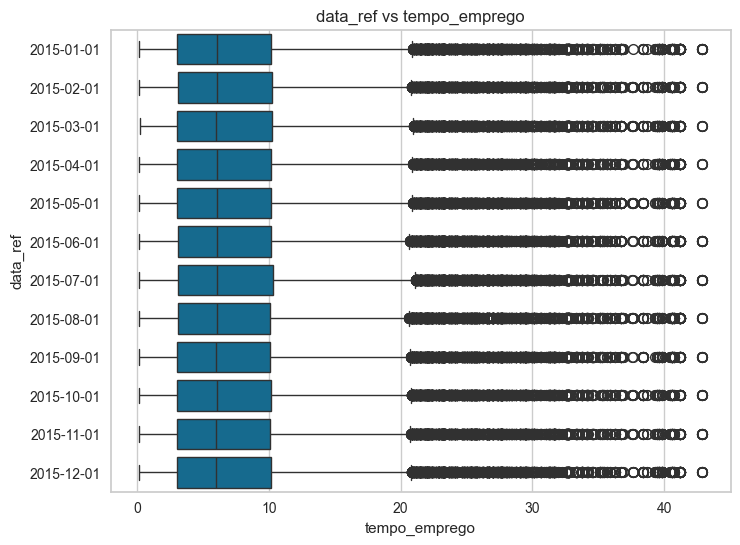

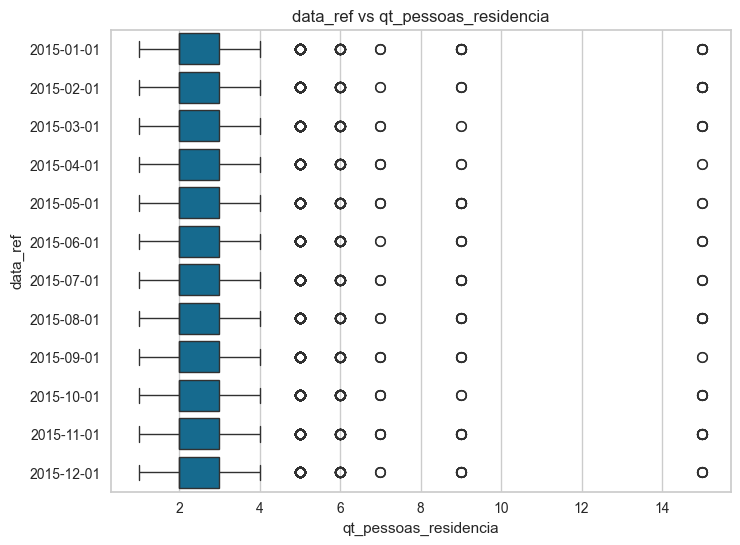

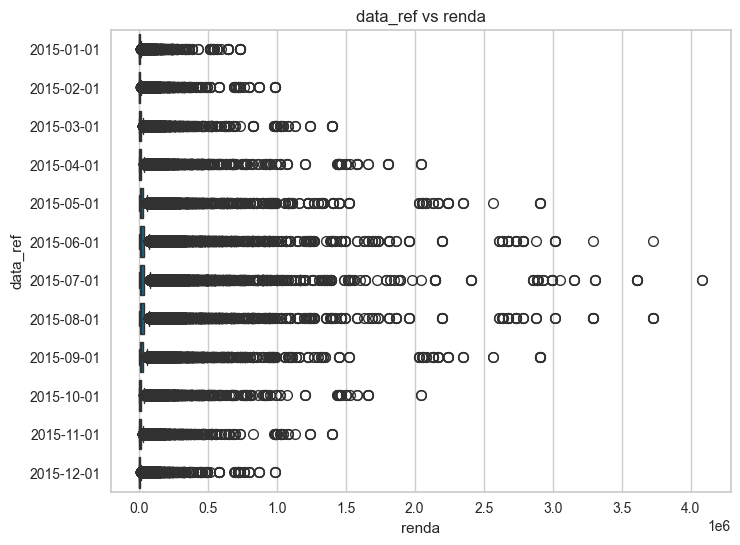

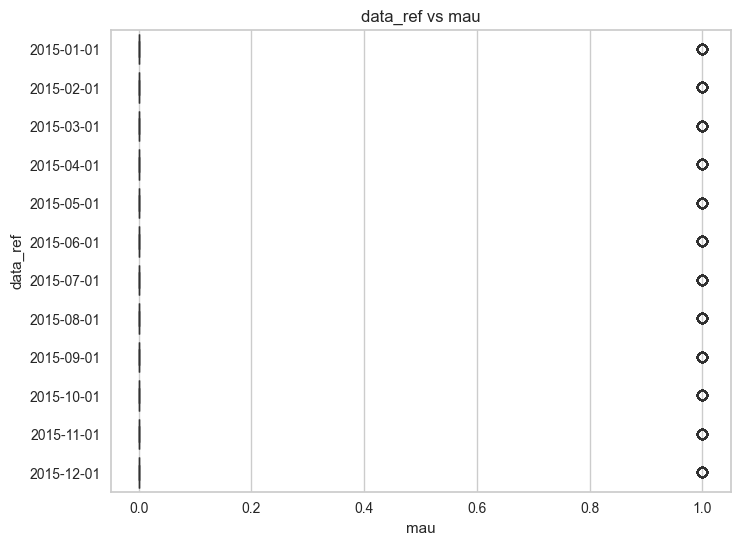

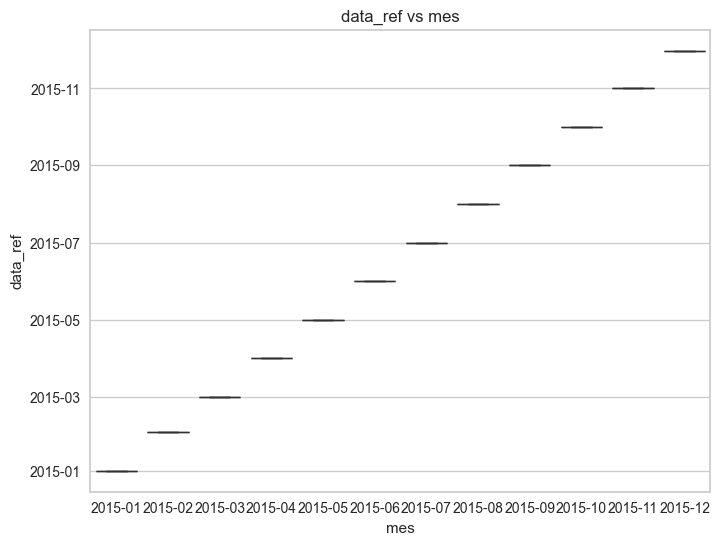

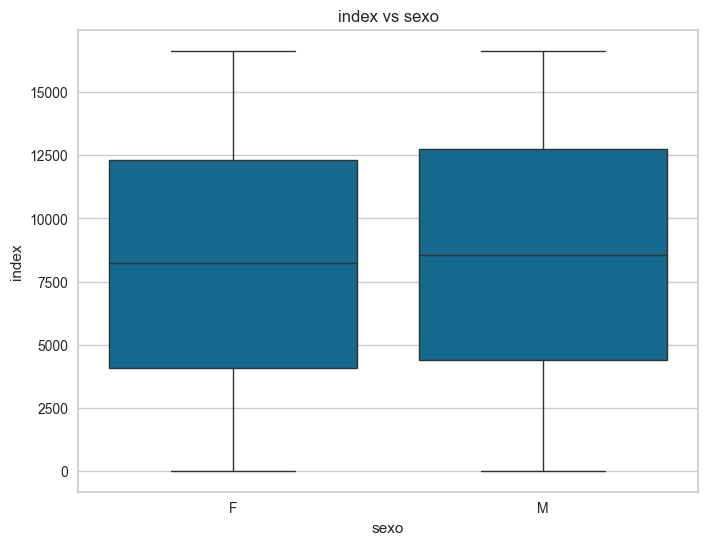

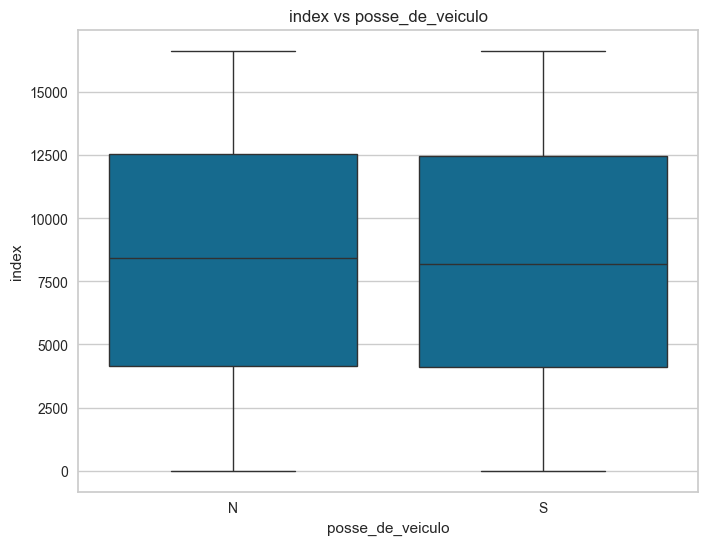

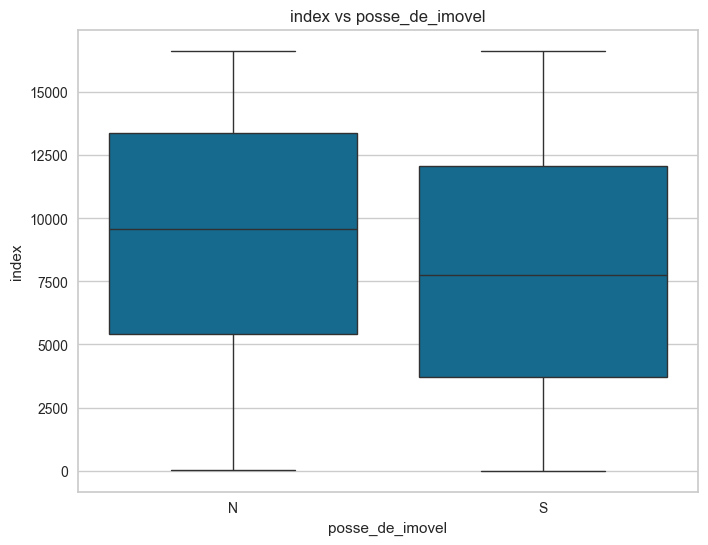

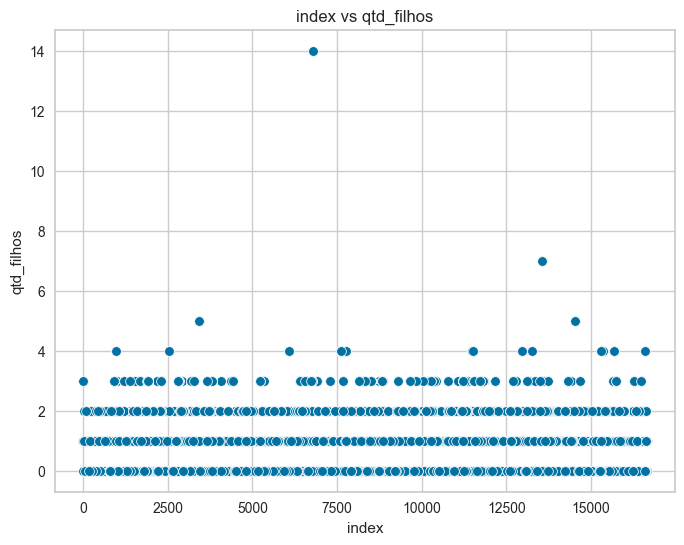

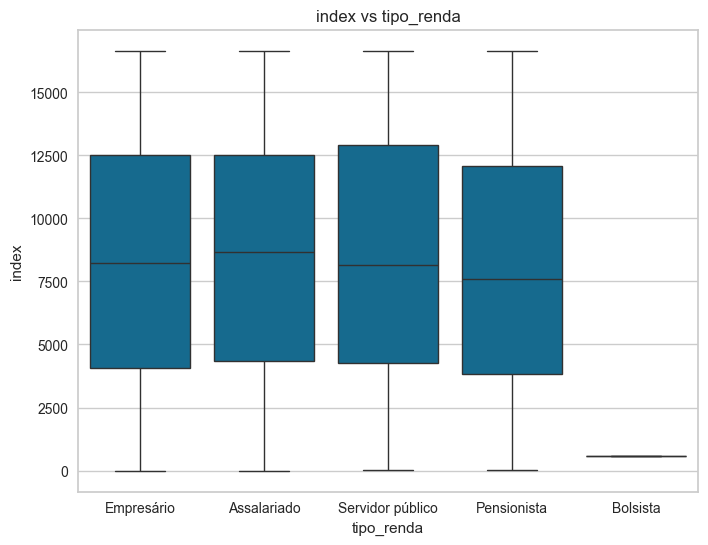

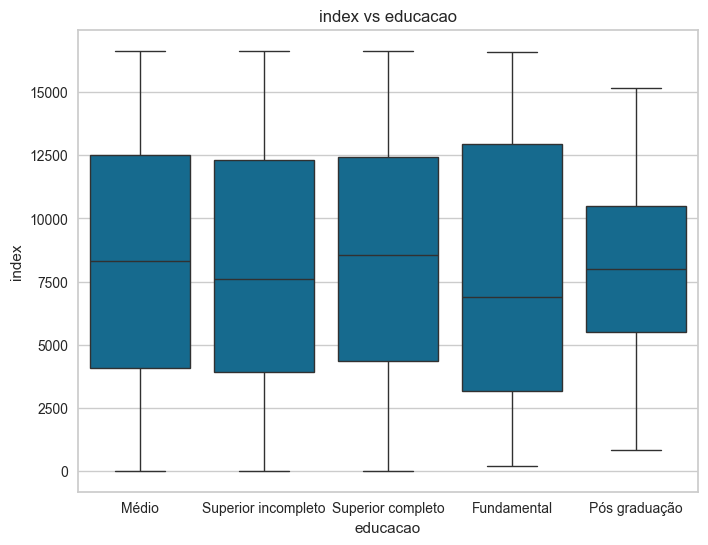

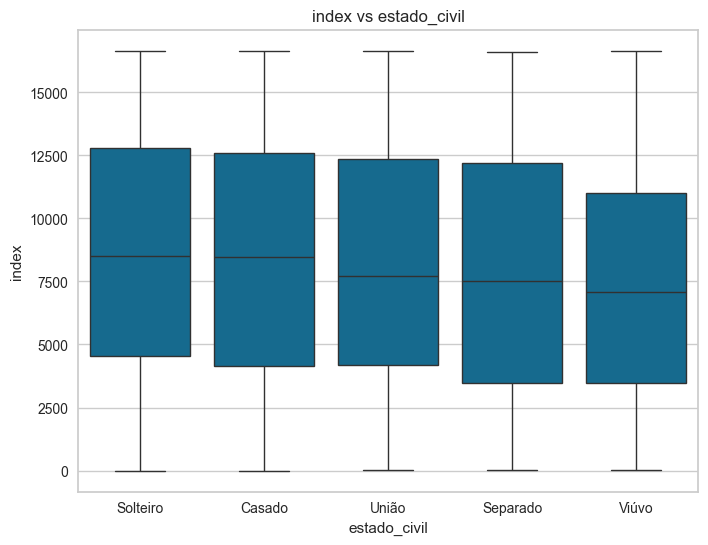

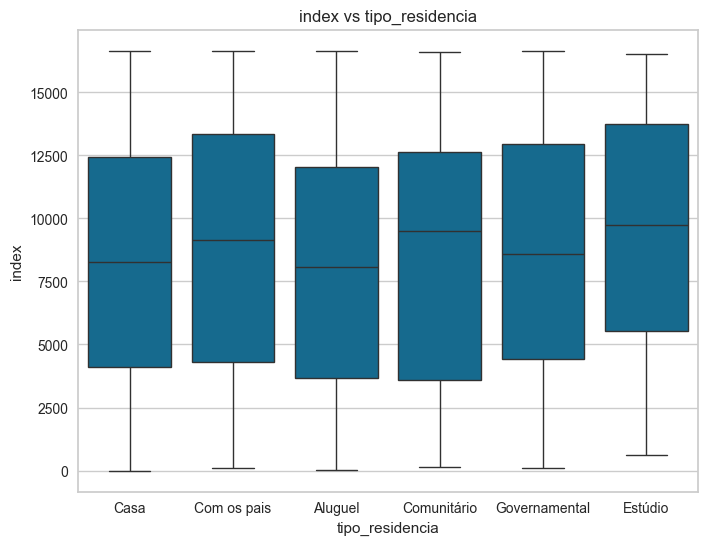

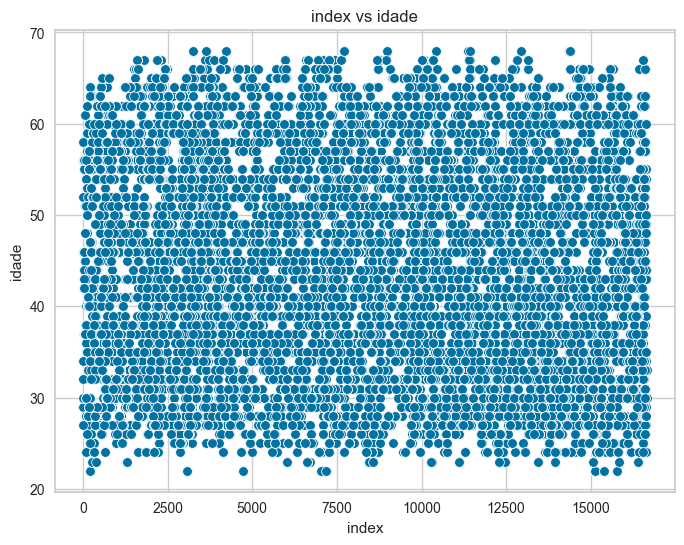

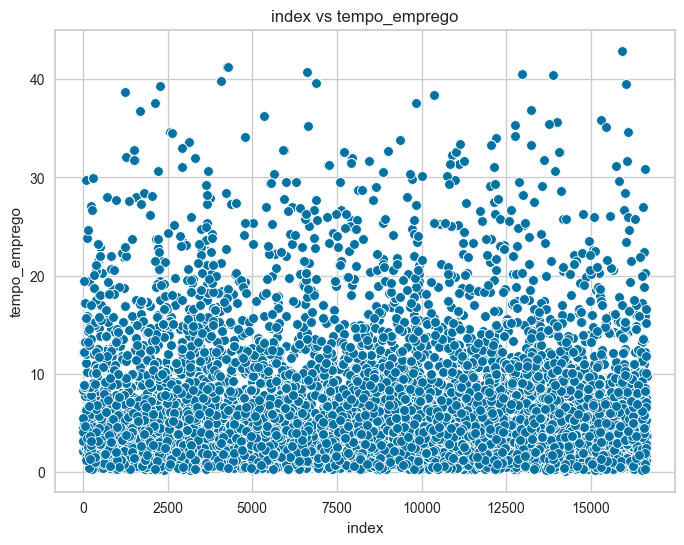

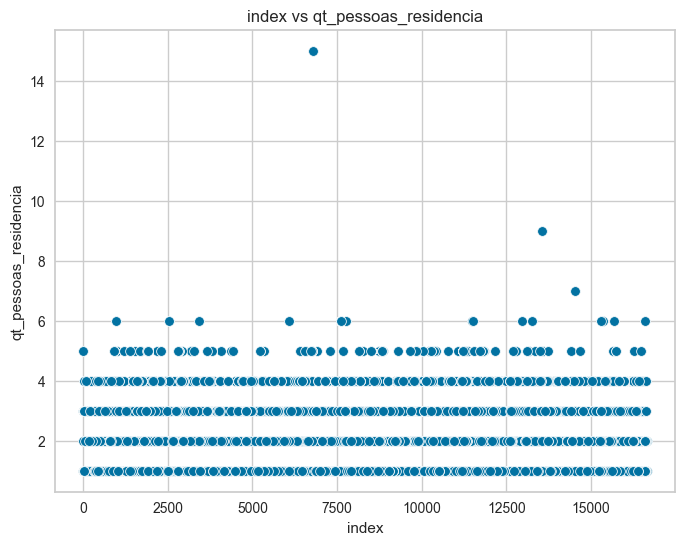

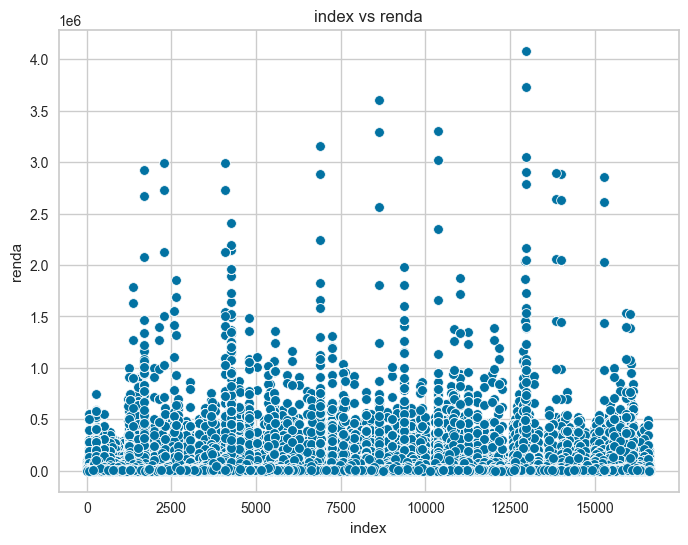

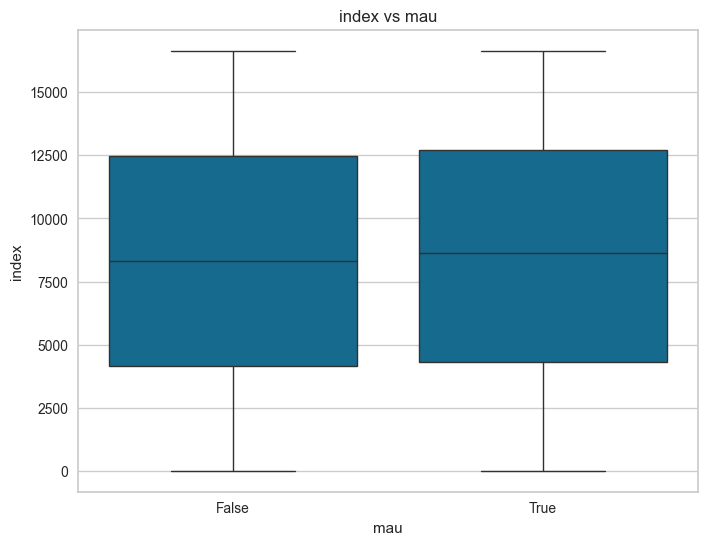

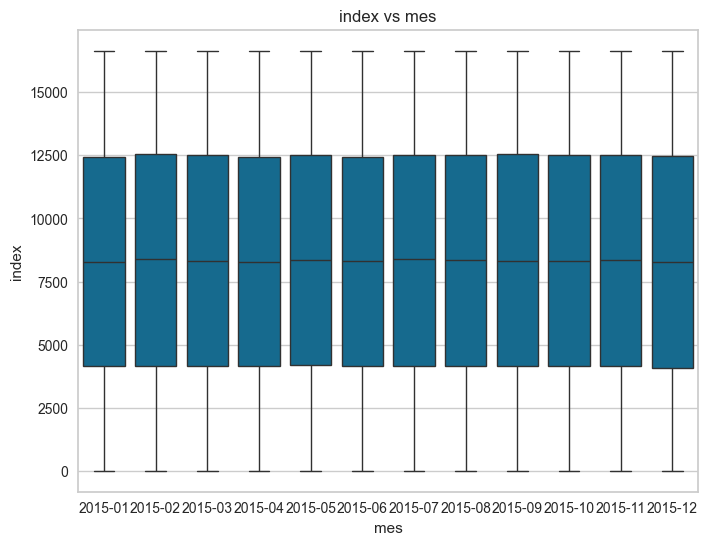

<Figure size 800x600 with 0 Axes>

In [9]:
qualitativas = df_treino.select_dtypes(include=['object', 'float']).columns
quantitativas =df_treino.select_dtypes(include=['float64', 'int64']).columns

pares = [(x, y) for i, x in enumerate(df_treino.columns) for y in df_treino.columns[i+1:]]

for var1, var2 in pares:
    plt.figure(figsize=(8,6))

    if var1 in qualitativas and var2 in qualitativas:
        sns.countplot(data=df_treino, x=var1, y=var2)
        plt.title(f"{var1} vs {var2}")

    elif var1 in quantitativas and var2 in quantitativas:
        sns.scatterplot(data=df_treino, x=var1, y=var2)
        plt.title(f"{var1} vs {var2}")

    else:
        if var1 in qualitativas:
            sns.boxplot(data=df_treino, x=var1, y=var2)
        else:
            sns.boxplot(data=df_treino, x=var2, y=var1)
        plt.title(f"{var1} vs {var2}")

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [10]:
df_treino.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
mes                           0
dtype: int64

In [11]:
porcentagem = (df_treino.tempo_emprego.isna().sum() / df_treino.tempo_emprego.shape) * 100
print(f'A porcentagem de valores nulos do df é: {float(porcentagem):.2f}%')

A porcentagem de valores nulos do df é: 16.81%


In [12]:
df_treino.tempo_emprego.max()

42.90684931506849

In [13]:
df_treino.tempo_emprego.min()

0.1178082191780822

In [14]:
df_treino.tempo_emprego.mean()

7.747992318063461

In [15]:
def preencher_nulos(df, coluna, variaveis_preditoras):
    df_na = df[df[coluna].notna()]
    df_faltantes = df[df[coluna].isna()]

    modelo_na = RandomForestRegressor(random_state=42)
    modelo_na.fit(df_na[variaveis_preditoras], df_na[coluna])

    df.loc[df[coluna].isna(), coluna] = modelo_na.predict(df_faltantes[variaveis_preditoras])

In [16]:
preencher_nulos(df_treino, 'tempo_emprego', ['idade', 'renda'])

In [17]:
df_treino.tempo_emprego.max()

42.90684931506849

In [18]:
df_treino.tempo_emprego.min()

0.1178082191780822

In [19]:
df_treino.tempo_emprego.mean()

7.62584644309367

In [20]:
df_treino.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
mes                      0
dtype: int64

## Tratando 'zero estruturais'

In [21]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,
F,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


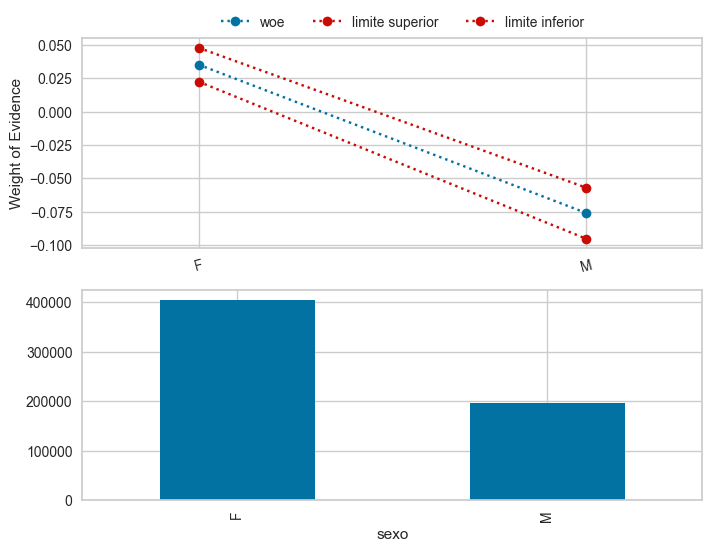

In [22]:
biv_discreta('sexo', df_treino)

,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,
N,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


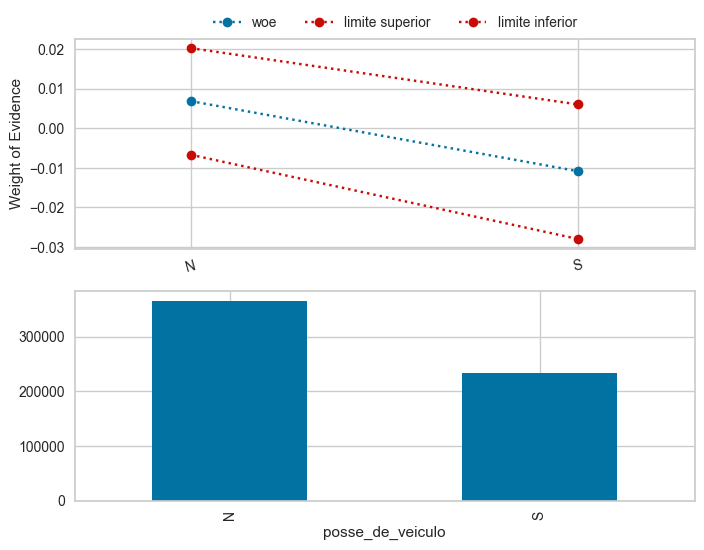

In [23]:
biv_discreta('posse_de_veiculo', df_treino)

,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,
N,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


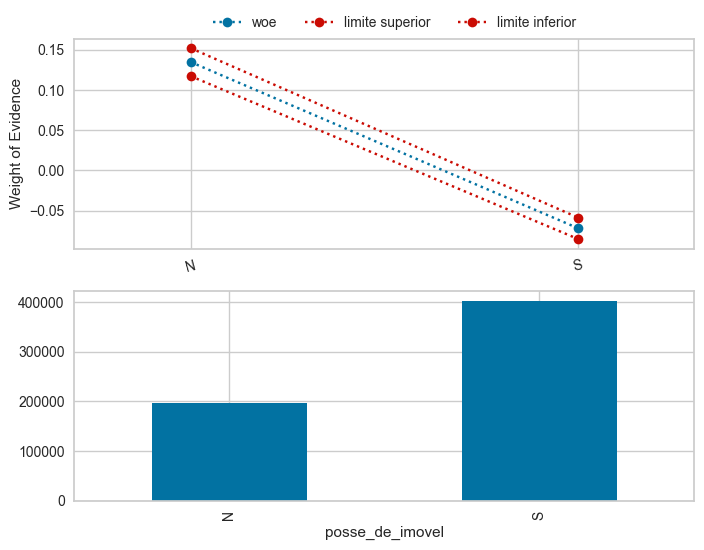

In [24]:
biv_discreta('posse_de_imovel', df_treino)

,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,
Assalariado,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


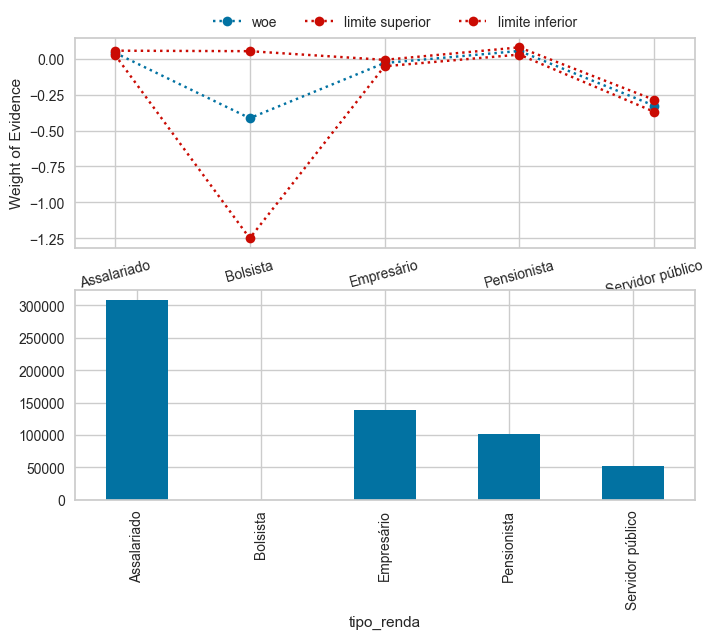

In [25]:
biv_discreta('tipo_renda', df_treino)

,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,
Fundamental,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


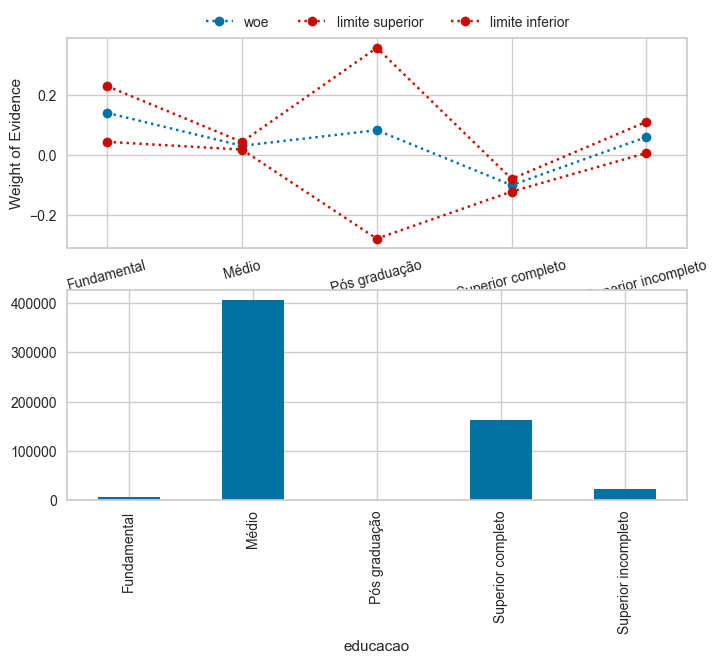

In [26]:
biv_discreta('educacao', df_treino)

,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,
Casado,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


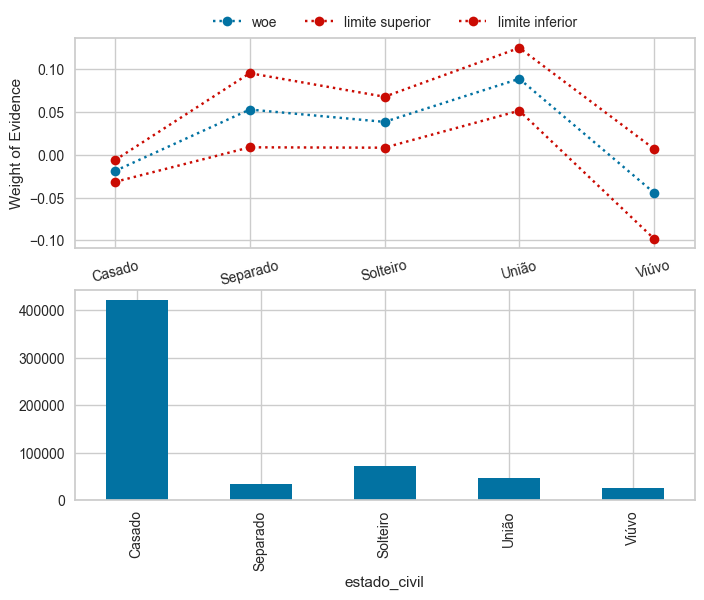

In [27]:
biv_discreta('estado_civil', df_treino)

,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,
Aluguel,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


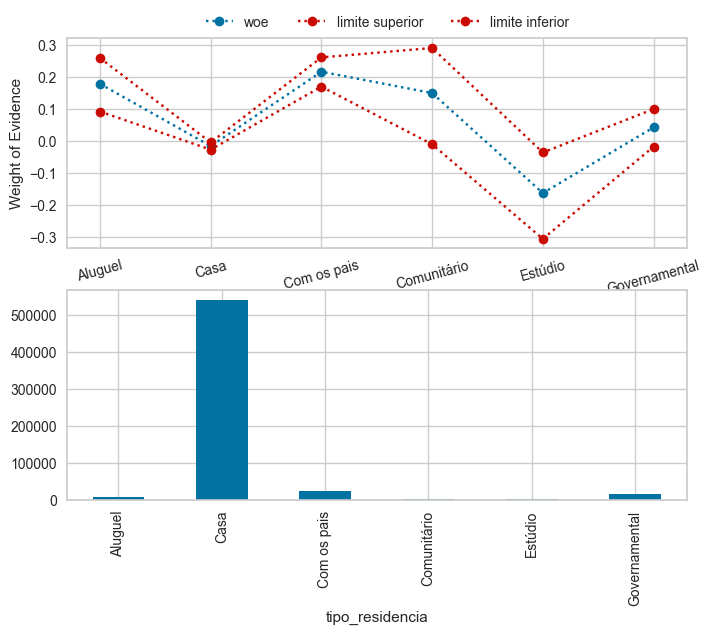

In [28]:
biv_discreta('tipo_residencia', df_treino)

In [29]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

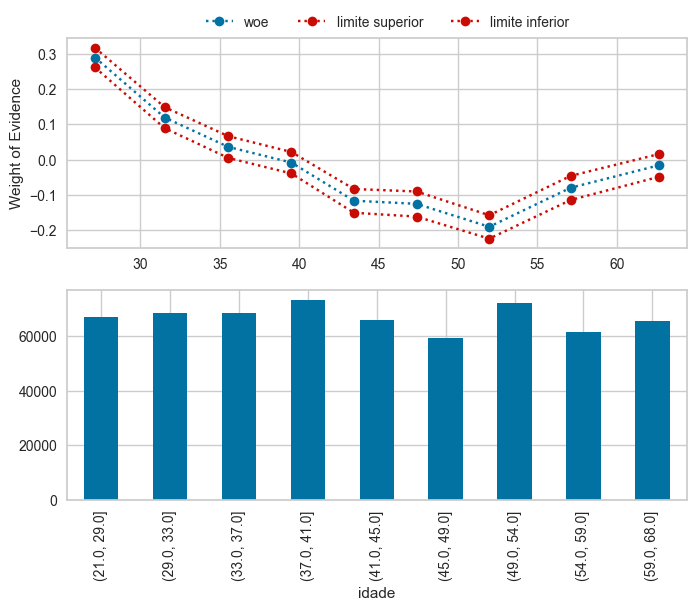

In [30]:
biv_continua('idade', 9, df_treino)

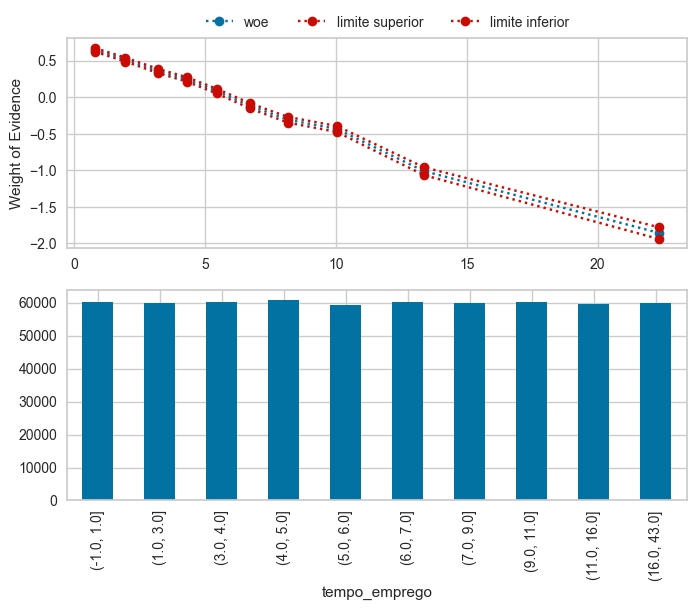

In [31]:
biv_continua('tempo_emprego', 10, df_treino)

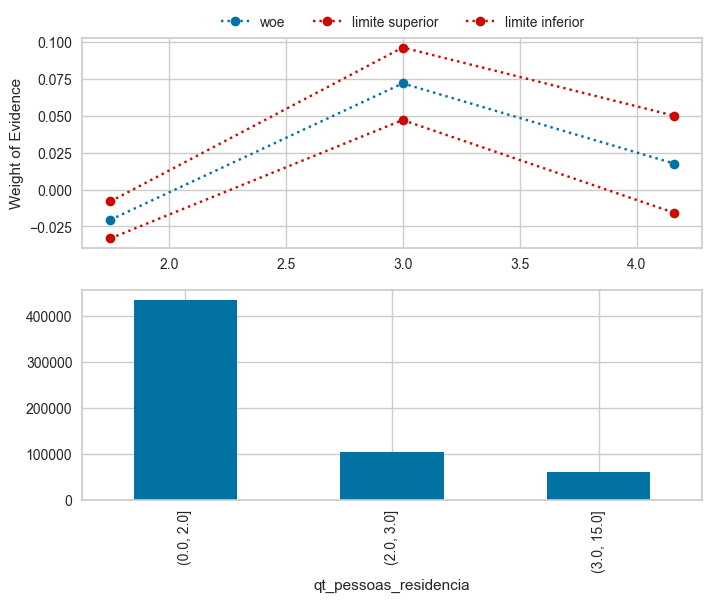

In [32]:
biv_continua('qt_pessoas_residencia', 4, df_treino)

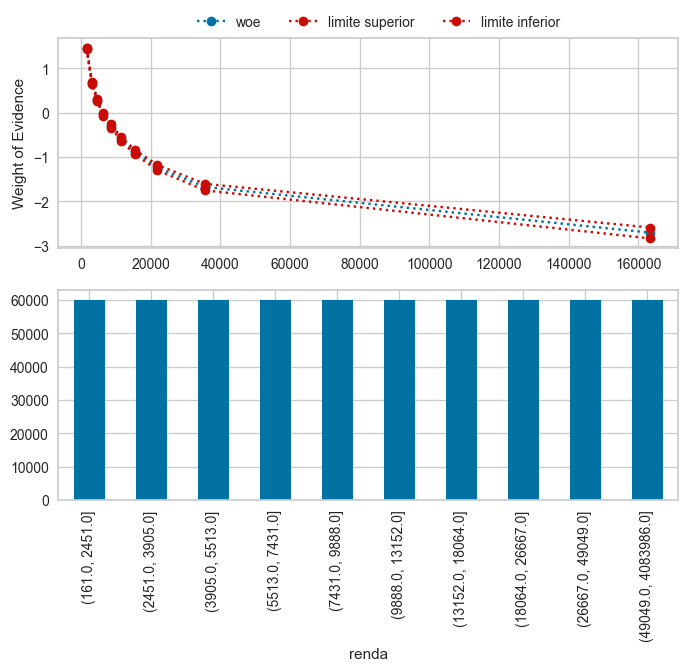

In [33]:
biv_continua('renda', 10, df_treino)

## Equação para mau

In [34]:
df_treino.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'mes', 'bom'],
      dtype='object')

In [35]:
df_treino.drop(columns=['data_ref', 'index', 'mes', 'bom'], inplace=True)

In [36]:
modelo = setup(data=df_treino, target='mau',
              normalize=True,
              transformation = True,
              remove_outliers=True,
              remove_multicollinearity = True, multicollinearity_threshold = 0.95,
              session_id=42)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 13)"
4,Transformed data shape,"(579022, 30)"
5,Transformed train set shape,"(399022, 30)"
6,Transformed test set shape,"(180000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9390,0.7713,0.0179,0.5287,0.0347,0.0308,0.0890
1,0.9388,0.7648,0.0117,0.4478,0.0228,0.0197,0.0645
2,0.9390,0.7737,0.0148,0.5067,0.0288,0.0254,0.0787
3,0.9393,0.7726,0.0191,0.5904,0.0370,0.0333,0.0984
4,0.9390,0.7756,0.0152,0.5132,0.0295,0.0261,0.0804
5,0.9392,0.7682,0.0148,0.5846,0.0289,0.0260,0.0861
6,0.9388,0.7691,0.0113,0.4462,0.0221,0.0191,0.0633
7,0.9390,0.7697,0.0207,0.5096,0.0397,0.0351,0.0933
8,0.9392,0.7696,0.0168,0.5890,0.0326,0.0293,0.0920


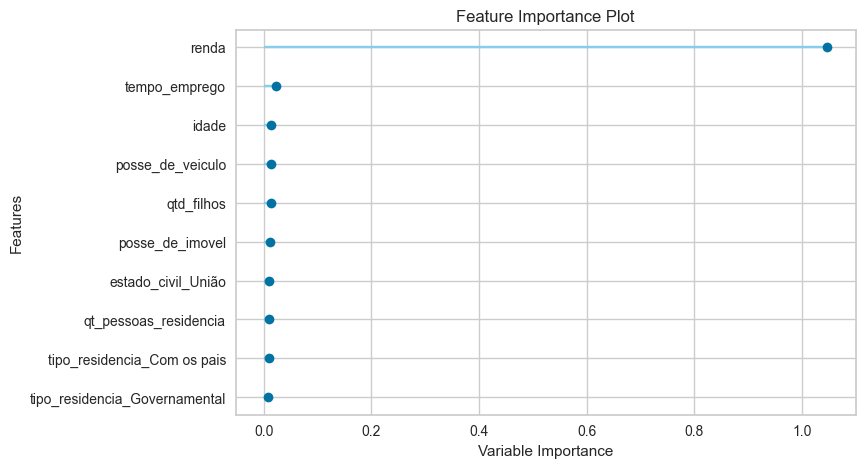

In [37]:
logistic_model = create_model('lr')

plot_model(logistic_model, plot='feature')

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [38]:
evaluate_model(logistic_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
previsao_val = predict_model(logistic_model, df_val)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8545,0.7390,0.0776,0.5260,0.1353,0.1014,0.1595


In [44]:
previsao_val

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mes,mau,prediction_label,prediction_score
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.489990,2016-01,True,0,0.8882
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471232,2.0,6278.370117,2016-01,False,0,0.9432
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.179688,2016-01,False,0,0.9705
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794520,3.0,2875.810059,2016-01,False,0,0.8739
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.189941,2016-01,False,0,0.8780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.989990,2016-03,False,0,0.8465
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.390015,2016-03,False,0,0.7744
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.059998,2016-03,True,0,0.5922
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.720215,2016-03,True,0,0.9194


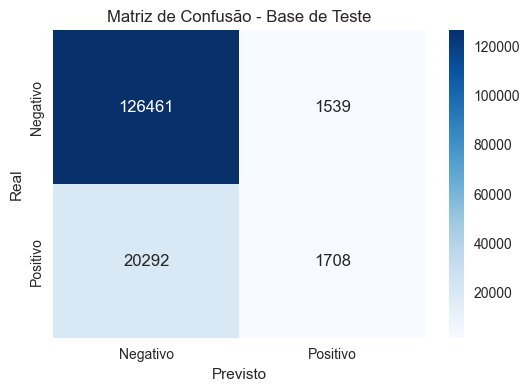

In [47]:
cm = confusion_matrix(previsao_val['mau'], previsao_val['prediction_label'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Base de Teste')
plt.show()

## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [62]:
class DropNaNTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.dropna()

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [63]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - self.multiplier * IQR
        upper_bound = Q3 + self.multiplier * IQR
        return X.clip(lower=lower_bound, upper=upper_bound, axis=1)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [64]:
class StepwiseFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, direction="forward", n_features_to_select="auto"):

        self.estimator = estimator if estimator else LinearRegression()
        self.direction = direction
        self.n_features_to_select = n_features_to_select
        self.selector = None

    def fit(self, X, y):
        self.selector = SequentialFeatureSelector(
            self.estimator,
            direction=self.direction,
            n_features_to_select=self.n_features_to_select,
            scoring=None,
            cv=3,
        ).fit(X, y)
        return self

    def transform(self, X):
        if self.selector is None:
            raise RuntimeError("O selector precisa ser ajustado antes de transformar os dados.")
        return self.selector.transform(X)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [65]:
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    col_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    return pd.DataFrame(X_pca, columns=col_names)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [66]:
def apply_get_dummies(df, columns=None, drop_first=False):

    if columns is None:
        columns = df.select_dtypes(include=['object', 'category']).columns
    
    df_dummies = pd.get_dummies(df, columns=columns, drop_first=drop_first)
    return df_dummies

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [67]:
def create_pipeline(n_components=5, outlier_multiplier=1.5, drop_first=True, stepwise_features="auto"):
    numeric_transformer = Pipeline(steps=[
        ('outlier', OutlierTransformer(multiplier=outlier_multiplier)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first' if drop_first else None))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
            ('cat', categorical_transformer, make_column_selector(dtype_include=['object', 'category']))
        ]
    )

    pipeline = Pipeline(steps=[
        ('drop_nan', DropNaNTransformer()),
        ('preprocessor', preprocessor),
        ('stepwise', StepwiseFeatureSelector(n_features_to_select=stepwise_features))
    ])

    return pipeline

In [68]:
pipeline = create_pipeline(n_components=5, outlier_multiplier=1.5)

### Treinar um modelo de regressão logistica com o resultado

In [70]:
df_treino.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')

In [74]:
modelo = setup(data=df_treino, target='mau',
              ignore_features=['sexo', 'posse_de_imovel', 'qtd_filhos',  'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'qt_pessoas_residencia'],
              normalize=True,
              transformation = True,
              remove_outliers=True,
              remove_multicollinearity = True, multicollinearity_threshold = 0.95,
              session_id=42)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 13)"
4,Transformed data shape,"(579006, 4)"
5,Transformed train set shape,"(399006, 4)"
6,Transformed test set shape,"(180000, 4)"
7,Ignore features,9
8,Numeric features,2
9,Categorical features,1


In [79]:
melhor_modelo = create_model('lr', penalty='l2', C=0.5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9390,0.7714,0.0086,0.5641,0.0169,0.0151,0.0640
1,0.9390,0.7647,0.0055,0.6087,0.0108,0.0097,0.0535
2,0.9391,0.7737,0.0078,0.6061,0.0154,0.0139,0.0638
3,0.9392,0.7725,0.0082,0.6774,0.0162,0.0147,0.0700
4,0.9389,0.7757,0.0066,0.4722,0.0131,0.0114,0.0503
5,0.9390,0.7683,0.0039,0.5556,0.0077,0.0069,0.0428
6,0.9390,0.7693,0.0051,0.5417,0.0100,0.0089,0.0480
7,0.9392,0.7697,0.0094,0.6857,0.0185,0.0168,0.0753
8,0.9392,0.7700,0.0082,0.7000,0.0162,0.0148,0.0713


In [80]:
modelo_tunado = tune_model(melhor_modelo)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9390,0.7714,0.0086,0.5641,0.0169,0.0151,0.0640
1,0.9390,0.7647,0.0055,0.6087,0.0108,0.0097,0.0535
2,0.9391,0.7737,0.0078,0.6061,0.0154,0.0139,0.0638
3,0.9392,0.7725,0.0082,0.6774,0.0162,0.0147,0.0700
4,0.9389,0.7757,0.0066,0.4722,0.0131,0.0114,0.0503
5,0.9390,0.7683,0.0039,0.5556,0.0077,0.0069,0.0428
6,0.9390,0.7693,0.0051,0.5417,0.0100,0.0089,0.0480
7,0.9392,0.7697,0.0094,0.6857,0.0185,0.0168,0.0753
8,0.9392,0.7700,0.0082,0.7000,0.0162,0.0148,0.0713


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Salvar o pickle file do modelo treinado

In [82]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(modelo_tunado, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [83]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [84]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [91]:
modelo = setup(data=df_treino, target='mau',
              ignore_features=['sexo', 'posse_de_imovel', 'qtd_filhos',  'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'qt_pessoas_residencia'],
              normalize=True,
              transformation = True,
              pca=True,
              pca_components=3,
              remove_outliers=True,
              remove_multicollinearity = True, multicollinearity_threshold = 0.95,
              session_id=42)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 13)"
4,Transformed data shape,"(579006, 4)"
5,Transformed train set shape,"(399006, 4)"
6,Transformed test set shape,"(180000, 4)"
7,Ignore features,9
8,Numeric features,2
9,Categorical features,1


In [92]:
xxx = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9390,0.7681,0.0086,0.5116,0.0169,0.0149,0.0602
1,0.9390,0.7628,0.0078,0.5405,0.0154,0.0137,0.0595
2,0.9392,0.7719,0.0101,0.6190,0.0199,0.0180,0.0737
3,0.9392,0.7709,0.0097,0.6579,0.0192,0.0175,0.0750
4,0.9390,0.7734,0.0101,0.5306,0.0199,0.0176,0.0670
5,0.9391,0.7677,0.0078,0.6061,0.0154,0.0139,0.0638
6,0.9390,0.7668,0.0070,0.5625,0.0139,0.0124,0.0578
7,0.9393,0.7678,0.0125,0.6400,0.0245,0.0222,0.0835
8,0.9393,0.7680,0.0105,0.6750,0.0207,0.0189,0.0792


In [93]:
lightgbm_tunado = tune_model(xxx, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9390,0.7700,0.0062,0.5161,0.0123,0.0109,0.0516
1,0.9390,0.7643,0.0051,0.5909,0.0101,0.0090,0.0507
2,0.9390,0.7729,0.0051,0.5417,0.0100,0.0089,0.0480
3,0.9390,0.7721,0.0039,0.5882,0.0077,0.0069,0.0443
4,0.9390,0.7750,0.0062,0.5333,0.0123,0.0109,0.0527
5,0.9390,0.7679,0.0031,0.5333,0.0062,0.0055,0.0373
6,0.9389,0.7683,0.0039,0.4545,0.0077,0.0067,0.0376
7,0.9392,0.7681,0.0086,0.6667,0.0169,0.0154,0.0709
8,0.9391,0.7693,0.0074,0.6552,0.0146,0.0133,0.0652


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [94]:
save_model(lightgbm_tunado, 'pipeline')

loaded_model = load_model('pipeline')
loaded_model

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\manoe\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['tempo_emprego', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=1.0,
                                importance_type='split', learning_rate=0.1,
                                max_depth=-1, min_child_samples=71,
                                min_child_weight=0.001, min_split_gain=0.6,
                                n_estimators=130, n_jobs=-1, num_leaves=4,
                                objective=None, random_state=42, reg_alpha=0.3,
                                reg_lambda=4, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [95]:
evaluate_model(lightgbm_tunado)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

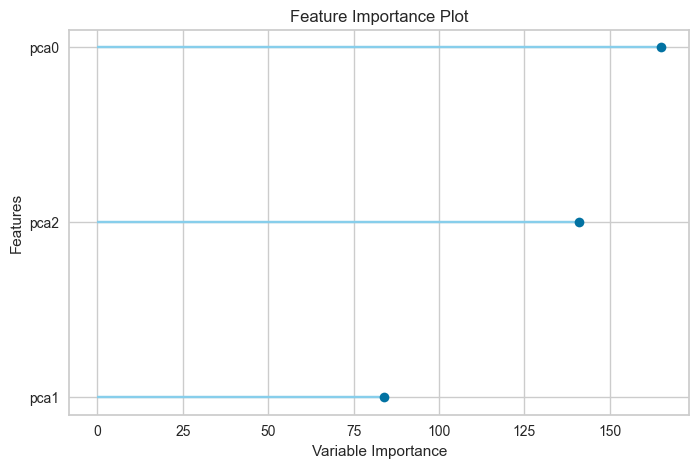

In [96]:
plot_model(lightgbm_tunado, plot='feature')

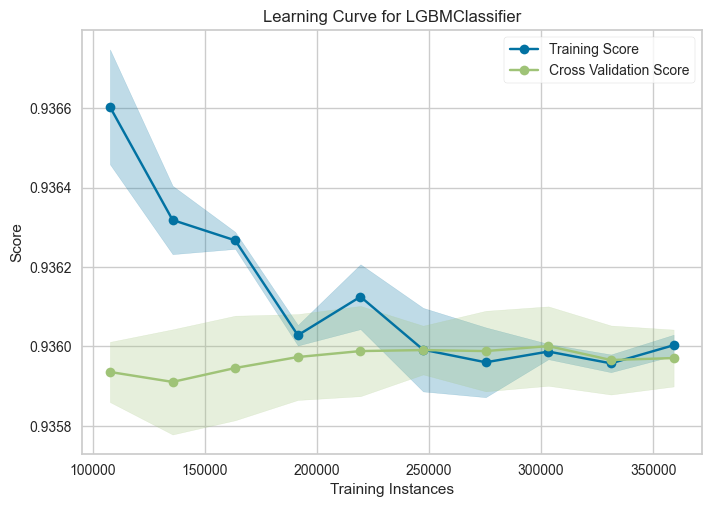

In [97]:
plot_model(lightgbm_tunado, plot='learning')

### Salvar o arquivo do modelo treinado

In [98]:
final_model = finalize_model(lightgbm_tunado)

In [99]:
save_model(final_model, 'model_finalizado')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tempo_emprego', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=['posse_de_veiculo'...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=1.0,
                             

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.